# Spatial Correlation Matrix to AOA

This repo aims to learn the AOA of LoRa beacons from Spatial Correlation Matrix, R. Here is the nice article how support vector method (e.g, SVR) can also be used for regression.

https://www.saedsayad.com/support_vector_machine_reg.htm

In [79]:
import os
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, accuracy_score
%matplotlib inline

## Preparation
Create dataset for training and testing from Rosbag recorded .csv file named as 'deg_(theta).csv'. Useful features lie in field 1, 2, 3, 6, 7, and 11 of the spatial correlation matrix, R.

In [2]:
data_dir = 'data_0106'
aoa_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[['field.data1', 'field.data2', 'field.data3', 'field.data6', 'field.data7', 'field.data11']]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[['field.data1', 'field.data2', 'field.data3', 'field.data6', 'field.data7', 'field.data11']]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [3]:
aoa_dict[-60].head()

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11
0,1.991174e-08,1.028969e-08,6.949319e-08,-2.010913e-07,6.824267e-08,0.000002
1,1.831539e-08,1.150122e-08,7.293450e-08,-1.223310e-07,1.623128e-07,0.000002
2,1.820912e-08,1.208390e-08,6.593048e-08,-1.448767e-07,1.018442e-07,0.000002
3,2.016857e-08,1.256068e-08,7.107637e-08,-1.344811e-07,9.275814e-08,0.000002
4,2.285401e-08,1.230451e-08,7.479932e-08,-1.361074e-07,1.538713e-07,0.000002


In [4]:
aoa_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field.data1   269 non-null    float64
 1   field.data2   269 non-null    float64
 2   field.data3   269 non-null    float64
 3   field.data6   269 non-null    float64
 4   field.data7   269 non-null    float64
 5   field.data11  269 non-null    float64
dtypes: float64(6)
memory usage: 12.7 KB


In [5]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Show detection of LoRa beacon when Rjk is significant
aoa_dict[0][abs(aoa_dict[0]['field.data1']) > 1e-04]

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11,theta
0,0.000399,-0.000359,-0.000245,-0.000937,0.001014,0.011725,0.0
14,0.006042,-0.004273,-0.002901,-0.016413,0.004441,0.104454,0.0
15,0.005552,-0.004102,-0.002887,-0.015961,0.002742,0.102230,0.0
16,0.005755,-0.004104,-0.003070,-0.017788,-0.001712,0.101776,0.0
17,0.004123,-0.004381,-0.004346,-0.014538,-0.000627,0.121335,0.0
...,...,...,...,...,...,...,...
258,0.005880,-0.001043,0.000075,-0.000127,0.009145,0.014606,0.0
259,0.006537,-0.001173,0.000117,0.000152,0.010935,0.016574,0.0
260,0.006470,-0.001204,0.000089,-0.000045,0.011023,0.017472,0.0
261,0.006530,-0.001210,0.000076,-0.000214,0.011017,0.018170,0.0


In [7]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
for key in aoa_dict.keys():
    aoa_sig[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) < 1e-04].index)
    aoa_noi[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) >= 1e-04].index)

In [8]:
aoa_sig[60]

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11,theta
5,0.026438,-0.014055,-0.034578,-0.084833,-0.366615,0.195672,1.047198
6,0.026774,-0.013786,-0.034818,-0.082009,-0.367695,0.192285,1.047198
7,0.026639,-0.013434,-0.034519,-0.075749,-0.371168,0.185148,1.047198
8,0.026184,-0.014034,-0.034509,-0.088851,-0.379352,0.189543,1.047198
9,0.026539,-0.014476,-0.034825,-0.088819,-0.377695,0.197761,1.047198
...,...,...,...,...,...,...,...
407,0.000307,-0.002767,-0.003226,0.014748,-0.013180,0.039275,1.047198
408,0.000625,-0.002981,-0.003772,0.013551,-0.019973,0.039902,1.047198
409,0.000861,-0.003104,-0.004055,0.013314,-0.022932,0.040916,1.047198
410,0.001166,-0.003441,-0.004696,0.011603,-0.028606,0.043699,1.047198


In [9]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[-60], aoa_sig[-50], aoa_sig[-40], aoa_sig[-30], aoa_sig[-20], aoa_sig[-10], aoa_sig[0], aoa_sig[10], aoa_sig[20], aoa_sig[30], aoa_sig[40], aoa_sig[50], aoa_sig[60]], ignore_index=True)
Xaoa['theta'].value_counts()

 0.872665    145
-0.349066    138
 1.047198    125
 0.698132    114
 0.349066    101
 0.174533     95
-1.047198     92
-0.174533     89
 0.000000     78
-0.872665     71
-0.698132     70
 0.523599     58
-0.523599     55
Name: theta, dtype: int64

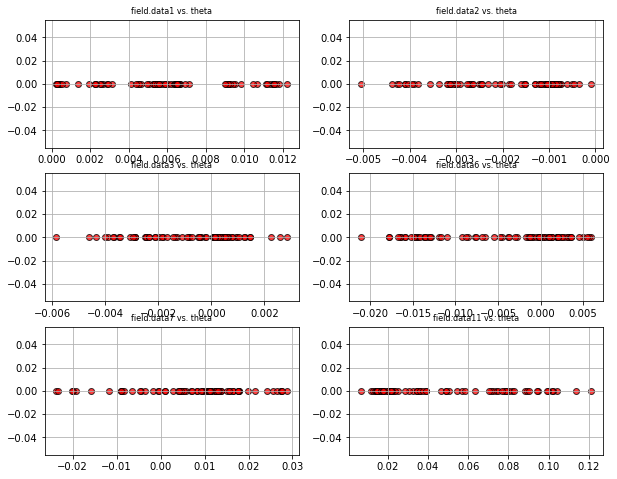

In [10]:
# Visualize data
fig,ax = plt.subplots(3,2,figsize=(10,8))
ax = ax.ravel()
visual_key = 0
for i in range(6):
    ax[i].scatter(aoa_sig[visual_key][aoa_sig[visual_key].columns[i]],aoa_sig[visual_key]['theta'],edgecolor='k',color='red',alpha=0.75)
    ax[i].set_title(f"{aoa_sig[visual_key].columns[i]} vs. theta",fontsize=8)
    ax[i].grid(True)
plt.show()

## Training
### SVR
Here is scikit-learn's SVR doc: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [11]:
X = Xaoa.drop('theta', axis=1)
y = Xaoa['theta']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
'''
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
'''

'\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.fit_transform(X_test)\n'

### Kernal arg: 'rbf' vs 'sigmoid' vs 'linear'

In [14]:
# Support vector regressor with Gaussian (Radial Basis Function) kernel
svr_1 = SVR(kernel='rbf',gamma='scale', C=2.0, epsilon=0.3)
svr_1.fit(X_train, y_train) 

SVR(C=2.0, epsilon=0.3)

In [15]:
svr_1.score(X_test,y_test)

0.6518584896816233

In [16]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_1.predict(X_test))))

RMSE for RBF kernelized SVR: 0.3852566354423806


In [17]:
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_1,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=SVR(C=2.0, epsilon=0.3),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5],
                         'epsilon': [0.1, 0.2, 0.5, 1]},
             return_train_score=True, scoring='r2', verbose=1)

In [18]:
grid.best_estimator_

SVR(C=5)

In [19]:
svr_best=SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.3)
svr_best.fit(X_train, y_train)
svr_best.score(X_test, y_test)

0.6752965450870837

In [20]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_best.predict(X_test))))

RMSE for RBF kernelized SVR: 0.3720623097177503


In [21]:
low_bound = 150
high_bound = 200
pred_y = svr_best.predict(X_test[low_bound:high_bound])
print(pred_y)

[ 0.75738927 -0.59503799  0.28668487  0.41931718  0.1850472   1.1946854
  0.31556508  0.11971728  0.61187773 -1.26512792 -0.62379803  0.55730759
  0.95881409 -0.01770198  0.59672676  0.13778572  0.14149431  0.26747001
  0.26169637  0.2328935  -0.89847703 -0.70399804  0.19548203  0.4561583
  0.42541049  0.3930561  -0.61438316 -0.85609786 -0.98755323  0.12861823
  0.22192352 -0.41779257 -0.89800314 -0.56934451 -0.71096435  0.24147868
 -0.70282857  0.87889231 -0.28738258  0.17034688  0.53492913  0.18755434
  0.51664441  0.19672257 -0.45875119 -0.38609994  0.37397472 -0.62230089
 -0.75399445  0.36298371]


In [22]:
y_test[low_bound:high_bound]
print(y_test.shape)

(247,)


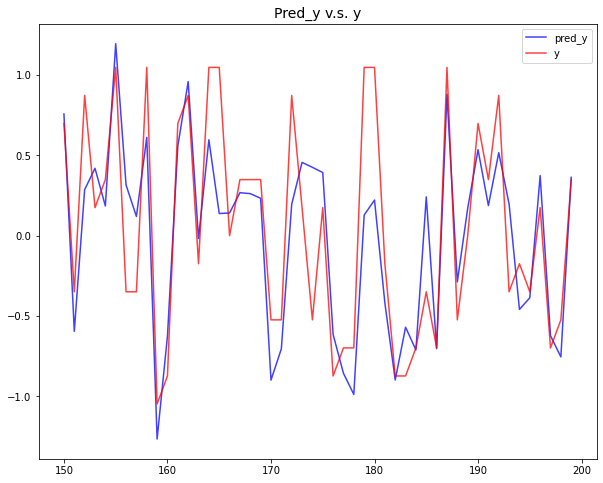

In [23]:
# Visualize data
fig2,ax2 = plt.subplots(1,1,figsize=(10,8))
ax2.plot([i for i in range(low_bound,high_bound)], list(pred_y), color='b', alpha=0.75, label='pred_y')
ax2.plot([i for i in range(low_bound,high_bound)], list(y_test.to_numpy()[low_bound:high_bound]), color='red', alpha=0.75, label='y')
ax2.set_title(f"Pred_y v.s. y",fontsize=14)
ax2.grid(False)
ax2.legend(loc='best')
plt.show()

### MLP ANN

In [24]:
le = LabelEncoder()

In [25]:
sc = StandardScaler()

In [26]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)
X_test_std

array([[-1.53383171,  0.80051723,  1.74631085,  0.22648122,  1.58839804,
        -0.94058144],
       [ 0.75257566, -1.68416192, -1.28193799, -0.92587037, -1.4398277 ,
         0.92463649],
       [-1.57333376,  1.21937269,  0.83804217,  0.49933774,  1.69796219,
        -0.74876525],
       ...,
       [ 1.18587644,  0.16399331, -0.33000171, -0.71226287, -0.85238085,
         0.63764808],
       [ 0.77518153,  0.06709535,  0.02762136, -0.84189231, -0.36725268,
         0.07994146],
       [-0.43136146, -0.19824806,  0.263634  , -0.42694175,  0.54900767,
        -0.48417788]])

In [27]:
y_train_std = le.fit_transform(y_train)
y_test_std = le.fit_transform(y_test)
y_test_std

array([ 6, 11,  3,  6, 12, 10,  8,  6,  1,  1,  4, 11,  2, 11, 11,  4,  7,
        4, 10,  4,  6,  4, 11, 12,  3, 11,  9, 12,  0,  0,  2, 10,  1,  4,
        8,  7,  6,  1, 11,  1, 10,  8,  5, 11,  2,  3,  7, 10,  4, 10,  8,
       11,  4,  0,  4, 12,  0,  4, 10,  8, 12,  7, 10,  8,  8,  8, 10, 11,
        0, 11, 10, 11,  0,  8, 12,  5, 11,  3, 11,  6, 10,  8,  0,  6,  0,
        9, 11,  0,  7, 10,  7, 12,  0,  4, 11,  2,  4,  9,  6, 12,  7,  2,
       11,  7,  0,  7,  7,  6, 11, 10,  1,  2, 12,  0,  7,  4,  8,  0,  0,
        5,  9,  1,  6, 12, 12,  6, 10,  4,  8,  6,  7, 12,  5,  5,  9,  4,
       12,  6,  6,  8, 10,  4,  4,  9, 12,  8,  7, 10,  5,  3, 10,  4, 11,
        7,  8, 12,  4,  4, 12,  0,  1, 10, 11,  5, 12, 12,  6,  8,  8,  8,
        3,  3, 11,  7,  3,  7,  1,  2,  2, 12, 12,  5,  1,  1,  2,  4,  2,
       12,  3,  6, 10,  8, 11,  4,  5,  4,  7,  2,  3,  8,  2,  5, 11,  1,
        6,  4,  4,  3,  2, 12, 11,  6,  8,  4,  7, 11,  2,  2,  8,  5, 12,
        4,  4, 11,  4,  6

In [28]:
mlpr = MLPRegressor(hidden_layer_sizes=4, random_state=1, max_iter=500)
mlpr.fit(X_train_std, y_train_std)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=4, max_iter=500, random_state=1)

## Autoencoder + FC
### Vanilla Autoencoder

In [29]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

Using TensorFlow backend.
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/

In [30]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()
print(X_train_np.shape)
print(y_train_np.shape)

(984, 6)
(984,)


In [31]:
mmsc = MinMaxScaler()
mmsc.fit(X_train_np)
X_train_np_std = mmsc.transform(X_train_np.astype("float32"))
X_test_np_std = mmsc.transform(X_test_np.astype("float32"))

In [32]:
maxX = np.max(X_train_np)
minX = np.min(X_train_np)
maxy = np.max(y_train_np)
miny = np.min(y_train_np)
#X_train_np_std = (X_train_np.astype("float32") - minX)/(maxX-minX)
#X_test_np_std = (X_test_np.astype("float32") - minX)/(maxX-minX)
y_train_np_std = (y_train_np.astype("float32") - miny)/(maxy-miny)
y_test_np_std = (y_test_np.astype("float32") - miny)/(maxy-miny)

In [33]:
y_test_np_std.shape

(247,)

In [34]:
input_size = 6
hidden_size = 4
output_size = 6

x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

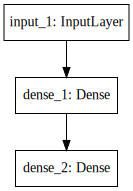

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#plot_model(autoencoder, to_file='vanilla_autoencoder.png', show_shapes=True)
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [36]:
epochs = 500
batch_size = 200

history = autoencoder.fit(X_train_np_std, X_train_np_std, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_np_std, X_test_np_std))



Train on 984 samples, validate on 247 samples
Epoch 1/500
984/984 [==============================] - 0s 449us/step - loss: 0.0888 - val_loss: 0.0860
Epoch 2/500
984/984 [==============================] - 0s 21us/step - loss: 0.0874 - val_loss: 0.0845
Epoch 3/500
984/984 [==============================] - 0s 50us/step - loss: 0.0859 - val_loss: 0.0831
Epoch 4/500
984/984 [==============================] - 0s 33us/step - loss: 0.0844 - val_loss: 0.0815
Epoch 5/500
984/984 [==============================] - 0s 14us/step - loss: 0.0829 - val_loss: 0.0800
Epoch 6/500
984/984 [==============================] - 0s 8us/step - loss: 0.0813 - val_loss: 0.0784
Epoch 7/500
984/984 [==============================] - 0s 17us/step - loss: 0.0797 - val_loss: 0.0768
Epoch 8/500
984/984 [==============================] - 0s 11us/step - loss: 0.0781 - val_loss: 0.0751
Epoch 9/500
984/984 [==============================] - 0s 23us/step - loss: 0.0764 - val_loss: 0.0734
Epoch 10/500
984/984 [============

984/984 [==============================] - 0s 25us/step - loss: 0.0293 - val_loss: 0.0282
Epoch 76/500
984/984 [==============================] - 0s 30us/step - loss: 0.0290 - val_loss: 0.0279
Epoch 77/500
984/984 [==============================] - 0s 19us/step - loss: 0.0287 - val_loss: 0.0276
Epoch 78/500
984/984 [==============================] - 0s 18us/step - loss: 0.0284 - val_loss: 0.0273
Epoch 79/500
984/984 [==============================] - 0s 19us/step - loss: 0.0281 - val_loss: 0.0270
Epoch 80/500
984/984 [==============================] - 0s 14us/step - loss: 0.0278 - val_loss: 0.0268
Epoch 81/500
984/984 [==============================] - 0s 23us/step - loss: 0.0275 - val_loss: 0.0265
Epoch 82/500
984/984 [==============================] - 0s 21us/step - loss: 0.0272 - val_loss: 0.0263
Epoch 83/500
984/984 [==============================] - 0s 20us/step - loss: 0.0270 - val_loss: 0.0260
Epoch 84/500
984/984 [==============================] - 0s 27us/step - loss: 0.0267 - 

984/984 [==============================] - 0s 16us/step - loss: 0.0181 - val_loss: 0.0176
Epoch 155/500
984/984 [==============================] - 0s 26us/step - loss: 0.0180 - val_loss: 0.0175
Epoch 156/500
984/984 [==============================] - 0s 22us/step - loss: 0.0179 - val_loss: 0.0175
Epoch 157/500
984/984 [==============================] - 0s 24us/step - loss: 0.0178 - val_loss: 0.0174
Epoch 158/500
984/984 [==============================] - 0s 24us/step - loss: 0.0178 - val_loss: 0.0173
Epoch 159/500
984/984 [==============================] - 0s 22us/step - loss: 0.0177 - val_loss: 0.0173
Epoch 160/500
984/984 [==============================] - 0s 23us/step - loss: 0.0176 - val_loss: 0.0172
Epoch 161/500
984/984 [==============================] - 0s 27us/step - loss: 0.0176 - val_loss: 0.0172
Epoch 162/500
984/984 [==============================] - 0s 24us/step - loss: 0.0175 - val_loss: 0.0171
Epoch 163/500
984/984 [==============================] - 0s 22us/step - loss: 

Epoch 233/500
984/984 [==============================] - 0s 16us/step - loss: 0.0136 - val_loss: 0.0134
Epoch 234/500
984/984 [==============================] - 0s 22us/step - loss: 0.0136 - val_loss: 0.0133
Epoch 235/500
984/984 [==============================] - 0s 25us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 236/500
984/984 [==============================] - 0s 34us/step - loss: 0.0135 - val_loss: 0.0132
Epoch 237/500
984/984 [==============================] - 0s 22us/step - loss: 0.0134 - val_loss: 0.0132
Epoch 238/500
984/984 [==============================] - 0s 20us/step - loss: 0.0134 - val_loss: 0.0131
Epoch 239/500
984/984 [==============================] - 0s 16us/step - loss: 0.0133 - val_loss: 0.0131
Epoch 240/500
984/984 [==============================] - 0s 16us/step - loss: 0.0133 - val_loss: 0.0130
Epoch 241/500
984/984 [==============================] - 0s 17us/step - loss: 0.0132 - val_loss: 0.0130
Epoch 242/500
984/984 [==============================] - 0s 24us

984/984 [==============================] - 0s 28us/step - loss: 0.0101 - val_loss: 0.0100
Epoch 312/500
984/984 [==============================] - 0s 21us/step - loss: 0.0101 - val_loss: 0.0099
Epoch 313/500
984/984 [==============================] - 0s 24us/step - loss: 0.0100 - val_loss: 0.0099
Epoch 314/500
984/984 [==============================] - 0s 24us/step - loss: 0.0100 - val_loss: 0.0099
Epoch 315/500
984/984 [==============================] - 0s 24us/step - loss: 0.0099 - val_loss: 0.0098
Epoch 316/500
984/984 [==============================] - 0s 29us/step - loss: 0.0099 - val_loss: 0.0098
Epoch 317/500
984/984 [==============================] - 0s 26us/step - loss: 0.0099 - val_loss: 0.0097
Epoch 318/500
984/984 [==============================] - 0s 25us/step - loss: 0.0098 - val_loss: 0.0097
Epoch 319/500
984/984 [==============================] - 0s 22us/step - loss: 0.0098 - val_loss: 0.0097
Epoch 320/500
984/984 [==============================] - 0s 22us/step - loss: 

984/984 [==============================] - 0s 17us/step - loss: 0.0074 - val_loss: 0.0073
Epoch 390/500
984/984 [==============================] - 0s 15us/step - loss: 0.0074 - val_loss: 0.0073
Epoch 391/500
984/984 [==============================] - 0s 30us/step - loss: 0.0073 - val_loss: 0.0073
Epoch 392/500
984/984 [==============================] - 0s 18us/step - loss: 0.0073 - val_loss: 0.0073
Epoch 393/500
984/984 [==============================] - 0s 16us/step - loss: 0.0073 - val_loss: 0.0072
Epoch 394/500
984/984 [==============================] - 0s 33us/step - loss: 0.0073 - val_loss: 0.0072
Epoch 395/500
984/984 [==============================] - 0s 16us/step - loss: 0.0072 - val_loss: 0.0072
Epoch 396/500
984/984 [==============================] - 0s 27us/step - loss: 0.0072 - val_loss: 0.0072
Epoch 397/500
984/984 [==============================] - 0s 18us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 398/500
984/984 [==============================] - 0s 19us/step - loss: 

984/984 [==============================] - 0s 27us/step - loss: 0.0053 - val_loss: 0.0053
Epoch 468/500
984/984 [==============================] - 0s 16us/step - loss: 0.0053 - val_loss: 0.0052
Epoch 469/500
984/984 [==============================] - 0s 18us/step - loss: 0.0053 - val_loss: 0.0052
Epoch 470/500
984/984 [==============================] - 0s 19us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 471/500
984/984 [==============================] - 0s 25us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 472/500
984/984 [==============================] - ETA: 0s - loss: 0.005 - 0s 22us/step - loss: 0.0052 - val_loss: 0.0051
Epoch 473/500
984/984 [==============================] - 0s 23us/step - loss: 0.0052 - val_loss: 0.0051
Epoch 474/500
984/984 [==============================] - 0s 13us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 475/500
984/984 [==============================] - 0s 12us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 476/500
984/984 [==============================]

In [37]:
pred_X_test_np_std = autoencoder.predict(X_test_np_std)

In [38]:
pred_X_test_np_std.shape

(247, 6)

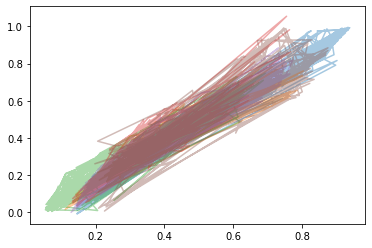

In [39]:
plt.plot(pred_X_test_np_std, X_test_np_std, alpha=.4)

dict_keys(['val_loss', 'loss'])


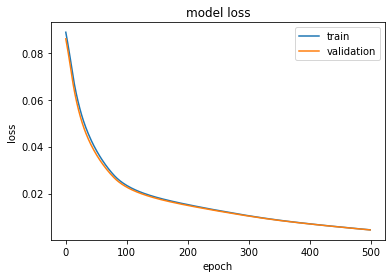

In [40]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [41]:
# Extract only the encoder model (discard the decoder)
encoder = Model(inputs=x, outputs=h)
#encoder.save("encoder.h5")
#plot_model(encoder, to_file='encoder.png', show_shapes=True)

### Multilayer Autoencoder

In [42]:
input_size = 6
h1_size = 5
h_size = 4
h2_size = 5
output_size = 6

x = Input(shape=(input_size,))
h1 = Dense(h1_size, activation='relu')(x)
h = Dense(h_size, activation='relu')(h1)
h2 = Dense(h2_size, activation='relu')(h)
r = Dense(output_size, activation='sigmoid')(h2)

autoencoder = Model(inputs=x, outputs=r)
for layer in autoencoder.layers:
    print(layer.output_shape)
autoencoder.compile(optimizer='adam', loss='mse')

(None, 6)
(None, 5)
(None, 4)
(None, 5)
(None, 6)


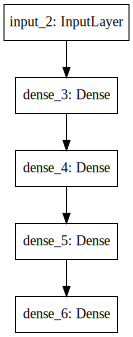

In [43]:
#plot_model(autoencoder, to_file='mlp_autoencoder.png', show_shapes=True)
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [44]:
epochs = 500
batch_size = 300

history = autoencoder.fit(X_train_np_std, X_train_np_std, batch_size=batch_size, epochs=epochs, validation_data=(X_test_np_std, X_test_np_std))

Train on 984 samples, validate on 247 samples
Epoch 1/500
984/984 [==============================] - 1s 655us/step - loss: 0.0754 - val_loss: 0.0721
Epoch 2/500
984/984 [==============================] - 0s 48us/step - loss: 0.0748 - val_loss: 0.0717
Epoch 3/500
984/984 [==============================] - 0s 67us/step - loss: 0.0744 - val_loss: 0.0712
Epoch 4/500
984/984 [==============================] - 0s 33us/step - loss: 0.0739 - val_loss: 0.0708
Epoch 5/500
984/984 [==============================] - 0s 11us/step - loss: 0.0735 - val_loss: 0.0704
Epoch 6/500
984/984 [==============================] - 0s 25us/step - loss: 0.0731 - val_loss: 0.0699
Epoch 7/500
984/984 [==============================] - 0s 16us/step - loss: 0.0726 - val_loss: 0.0695
Epoch 8/500
984/984 [==============================] - 0s 10us/step - loss: 0.0722 - val_loss: 0.0691
Epoch 9/500
984/984 [==============================] - 0s 13us/step - loss: 0.0718 - val_loss: 0.0686
Epoch 10/500
984/984 [=============

984/984 [==============================] - 0s 16us/step - loss: 0.0218 - val_loss: 0.0213
Epoch 81/500
984/984 [==============================] - 0s 17us/step - loss: 0.0215 - val_loss: 0.0211
Epoch 82/500
984/984 [==============================] - 0s 16us/step - loss: 0.0213 - val_loss: 0.0209
Epoch 83/500
984/984 [==============================] - 0s 22us/step - loss: 0.0211 - val_loss: 0.0207
Epoch 84/500
984/984 [==============================] - 0s 32us/step - loss: 0.0209 - val_loss: 0.0205
Epoch 85/500
984/984 [==============================] - 0s 18us/step - loss: 0.0206 - val_loss: 0.0203
Epoch 86/500
984/984 [==============================] - 0s 31us/step - loss: 0.0205 - val_loss: 0.0201
Epoch 87/500
984/984 [==============================] - 0s 19us/step - loss: 0.0203 - val_loss: 0.0199
Epoch 88/500
984/984 [==============================] - 0s 23us/step - loss: 0.0201 - val_loss: 0.0198
Epoch 89/500
984/984 [==============================] - 0s 25us/step - loss: 0.0199 - 

984/984 [==============================] - 0s 22us/step - loss: 0.0167 - val_loss: 0.0164
Epoch 159/500
984/984 [==============================] - 0s 18us/step - loss: 0.0167 - val_loss: 0.0164
Epoch 160/500
984/984 [==============================] - 0s 24us/step - loss: 0.0167 - val_loss: 0.0164
Epoch 161/500
984/984 [==============================] - 0s 17us/step - loss: 0.0167 - val_loss: 0.0164
Epoch 162/500
984/984 [==============================] - 0s 25us/step - loss: 0.0166 - val_loss: 0.0164
Epoch 163/500
984/984 [==============================] - 0s 15us/step - loss: 0.0166 - val_loss: 0.0164
Epoch 164/500
984/984 [==============================] - 0s 24us/step - loss: 0.0166 - val_loss: 0.0163
Epoch 165/500
984/984 [==============================] - 0s 15us/step - loss: 0.0166 - val_loss: 0.0163
Epoch 166/500
984/984 [==============================] - 0s 18us/step - loss: 0.0166 - val_loss: 0.0163
Epoch 167/500
984/984 [==============================] - 0s 21us/step - loss: 

Epoch 237/500
984/984 [==============================] - 0s 17us/step - loss: 0.0153 - val_loss: 0.0148
Epoch 238/500
984/984 [==============================] - 0s 17us/step - loss: 0.0152 - val_loss: 0.0148
Epoch 239/500
984/984 [==============================] - 0s 16us/step - loss: 0.0152 - val_loss: 0.0147
Epoch 240/500
984/984 [==============================] - 0s 17us/step - loss: 0.0152 - val_loss: 0.0147
Epoch 241/500
984/984 [==============================] - 0s 16us/step - loss: 0.0152 - val_loss: 0.0147
Epoch 242/500
984/984 [==============================] - 0s 19us/step - loss: 0.0151 - val_loss: 0.0146
Epoch 243/500
984/984 [==============================] - 0s 16us/step - loss: 0.0151 - val_loss: 0.0146
Epoch 244/500
984/984 [==============================] - 0s 19us/step - loss: 0.0151 - val_loss: 0.0146
Epoch 245/500
984/984 [==============================] - 0s 13us/step - loss: 0.0150 - val_loss: 0.0145
Epoch 246/500
984/984 [==============================] - 0s 17us

Epoch 316/500
984/984 [==============================] - 0s 11us/step - loss: 0.0109 - val_loss: 0.0105
Epoch 317/500
984/984 [==============================] - 0s 18us/step - loss: 0.0109 - val_loss: 0.0105
Epoch 318/500
984/984 [==============================] - 0s 31us/step - loss: 0.0108 - val_loss: 0.0104
Epoch 319/500
984/984 [==============================] - 0s 41us/step - loss: 0.0108 - val_loss: 0.0104
Epoch 320/500
984/984 [==============================] - 0s 19us/step - loss: 0.0107 - val_loss: 0.0104
Epoch 321/500
984/984 [==============================] - 0s 22us/step - loss: 0.0107 - val_loss: 0.0103
Epoch 322/500
984/984 [==============================] - 0s 79us/step - loss: 0.0106 - val_loss: 0.0103
Epoch 323/500
984/984 [==============================] - 0s 11us/step - loss: 0.0106 - val_loss: 0.0102
Epoch 324/500
984/984 [==============================] - 0s 11us/step - loss: 0.0105 - val_loss: 0.0102
Epoch 325/500
984/984 [==============================] - 0s 20us

Epoch 395/500
984/984 [==============================] - 0s 12us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 396/500
984/984 [==============================] - 0s 19us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 397/500
984/984 [==============================] - 0s 19us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 398/500
984/984 [==============================] - 0s 16us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 399/500
984/984 [==============================] - 0s 19us/step - loss: 0.0088 - val_loss: 0.0087
Epoch 400/500
984/984 [==============================] - 0s 18us/step - loss: 0.0087 - val_loss: 0.0087
Epoch 401/500
984/984 [==============================] - 0s 25us/step - loss: 0.0087 - val_loss: 0.0087
Epoch 402/500
984/984 [==============================] - 0s 20us/step - loss: 0.0087 - val_loss: 0.0086
Epoch 403/500
984/984 [==============================] - 0s 28us/step - loss: 0.0087 - val_loss: 0.0086
Epoch 404/500
984/984 [==============================] - 0s 19us

984/984 [==============================] - 0s 15us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 474/500
984/984 [==============================] - 0s 17us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 475/500
984/984 [==============================] - 0s 19us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 476/500
984/984 [==============================] - 0s 26us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 477/500
984/984 [==============================] - 0s 13us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 478/500
984/984 [==============================] - 0s 12us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 479/500
984/984 [==============================] - 0s 19us/step - loss: 0.0079 - val_loss: 0.0079
Epoch 480/500
984/984 [==============================] - 0s 21us/step - loss: 0.0079 - val_loss: 0.0079
Epoch 481/500
984/984 [==============================] - 0s 18us/step - loss: 0.0078 - val_loss: 0.0079
Epoch 482/500
984/984 [==============================] - 0s 20us/step - loss: 

dict_keys(['val_loss', 'loss'])


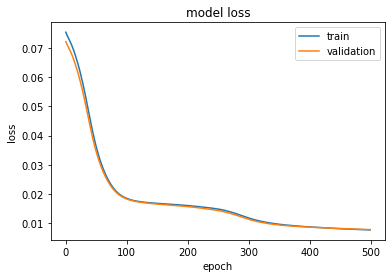

In [45]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [46]:
# Extract only encoder part
encoder = Model(inputs=x, outputs=h)

In [47]:
encode_X_test_np_std = encoder.predict(X_test_np_std)
encode_X_test_np_std.shape

(247, 4)

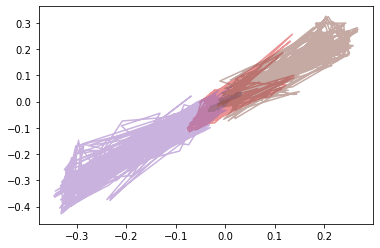

In [48]:
# Show autoencoder recovery
pred_X_test_np_std = autoencoder.predict(X_test_np_std)
pred_X_test_np = mmsc.inverse_transform(pred_X_test_np_std)

plt.plot(pred_X_test_np, X_test_np, alpha=.5)
plt.show()

### Classifier?!

In [89]:
aoa_classes = 13
# Float -> LabelEncoder -> OneHotEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
integer_encoded = label_encoder.transform(y_train)
#print(integer_encoded)
# binary encode OR np_utils.to_categorical SAME!
'''
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_onehot = onehot_encoder.fit_transform(integer_encoded)
'''
y_onehot = np_utils.to_categorical(integer_encoded, num_classes=aoa_classes)
y_onehot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [111]:
# Classifier
classifier = Sequential()
classifier.add(Dense(9, input_dim=4, activation='relu'))
classifier.add(Dense(13, activation='softmax'))

for layer in classifier.layers:
    print(layer.output_shape)
# Compile model
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

(None, 9)
(None, 13)


In [109]:
# Prepare validation_data = (X_test, y_test)
yt_onehot = np_utils.to_categorical(label_encoder.transform(y_test), num_classes=aoa_classes)
encode_X_train_np_std = encoder.predict(X_train_np_std)
encode_X_test_np_std = encoder.predict(X_test_np_std)
encode_X_test_np_std.shape

(247, 4)

In [110]:
epochs = 200
batch_size = 50

history = classifier.fit(encode_X_train_np_std, y_onehot, batch_size=batch_size, epochs=epochs, validation_data=(encode_X_test_np_std, yt_onehot))

Train on 984 samples, validate on 247 samples
Epoch 1/200
984/984 [==============================] - 1s 671us/step - loss: 2.6197 - categorical_accuracy: 0.0945 - val_loss: 2.5661 - val_categorical_accuracy: 0.1134
Epoch 2/200
984/984 [==============================] - 0s 46us/step - loss: 2.5691 - categorical_accuracy: 0.1148 - val_loss: 2.5243 - val_categorical_accuracy: 0.1296
Epoch 3/200
984/984 [==============================] - 0s 47us/step - loss: 2.5342 - categorical_accuracy: 0.1392 - val_loss: 2.4980 - val_categorical_accuracy: 0.1579
Epoch 4/200
984/984 [==============================] - 0s 70us/step - loss: 2.5098 - categorical_accuracy: 0.1748 - val_loss: 2.4778 - val_categorical_accuracy: 0.1700
Epoch 5/200
984/984 [==============================] - 0s 51us/step - loss: 2.4901 - categorical_accuracy: 0.1829 - val_loss: 2.4571 - val_categorical_accuracy: 0.1700
Epoch 6/200
984/984 [==============================] - 0s 47us/step - loss: 2.4675 - categorical_accuracy: 0.1850

984/984 [==============================] - 0s 64us/step - loss: 1.9241 - categorical_accuracy: 0.3303 - val_loss: 1.8881 - val_categorical_accuracy: 0.3360
Epoch 50/200
984/984 [==============================] - 0s 81us/step - loss: 1.9169 - categorical_accuracy: 0.3293 - val_loss: 1.8812 - val_categorical_accuracy: 0.3441
Epoch 51/200
984/984 [==============================] - 0s 49us/step - loss: 1.9101 - categorical_accuracy: 0.3303 - val_loss: 1.8756 - val_categorical_accuracy: 0.3401
Epoch 52/200
984/984 [==============================] - 0s 66us/step - loss: 1.9031 - categorical_accuracy: 0.3303 - val_loss: 1.8676 - val_categorical_accuracy: 0.3482
Epoch 53/200
984/984 [==============================] - 0s 76us/step - loss: 1.8980 - categorical_accuracy: 0.3364 - val_loss: 1.8611 - val_categorical_accuracy: 0.3644
Epoch 54/200
984/984 [==============================] - 0s 68us/step - loss: 1.8901 - categorical_accuracy: 0.3394 - val_loss: 1.8557 - val_categorical_accuracy: 0.3603

984/984 [==============================] - 0s 48us/step - loss: 1.7227 - categorical_accuracy: 0.4553 - val_loss: 1.6942 - val_categorical_accuracy: 0.4737
Epoch 98/200
984/984 [==============================] - 0s 56us/step - loss: 1.7199 - categorical_accuracy: 0.4522 - val_loss: 1.6920 - val_categorical_accuracy: 0.4575
Epoch 99/200
984/984 [==============================] - 0s 43us/step - loss: 1.7179 - categorical_accuracy: 0.4573 - val_loss: 1.6906 - val_categorical_accuracy: 0.4656
Epoch 100/200
984/984 [==============================] - 0s 44us/step - loss: 1.7154 - categorical_accuracy: 0.4583 - val_loss: 1.6866 - val_categorical_accuracy: 0.4615
Epoch 101/200
984/984 [==============================] - 0s 40us/step - loss: 1.7133 - categorical_accuracy: 0.4654 - val_loss: 1.6846 - val_categorical_accuracy: 0.4858
Epoch 102/200
984/984 [==============================] - 0s 40us/step - loss: 1.7102 - categorical_accuracy: 0.4614 - val_loss: 1.6831 - val_categorical_accuracy: 0.4

984/984 [==============================] - 0s 44us/step - loss: 1.6403 - categorical_accuracy: 0.4807 - val_loss: 1.6163 - val_categorical_accuracy: 0.4939
Epoch 146/200
984/984 [==============================] - 0s 39us/step - loss: 1.6383 - categorical_accuracy: 0.4827 - val_loss: 1.6168 - val_categorical_accuracy: 0.4858
Epoch 147/200
984/984 [==============================] - 0s 36us/step - loss: 1.6372 - categorical_accuracy: 0.4827 - val_loss: 1.6146 - val_categorical_accuracy: 0.4939
Epoch 148/200
984/984 [==============================] - 0s 42us/step - loss: 1.6356 - categorical_accuracy: 0.4817 - val_loss: 1.6138 - val_categorical_accuracy: 0.4737
Epoch 149/200
984/984 [==============================] - 0s 40us/step - loss: 1.6344 - categorical_accuracy: 0.4848 - val_loss: 1.6146 - val_categorical_accuracy: 0.4818
Epoch 150/200
984/984 [==============================] - 0s 42us/step - loss: 1.6337 - categorical_accuracy: 0.4827 - val_loss: 1.6117 - val_categorical_accuracy: 0

984/984 [==============================] - 0s 48us/step - loss: 1.5928 - categorical_accuracy: 0.4868 - val_loss: 1.5772 - val_categorical_accuracy: 0.4980
Epoch 194/200
984/984 [==============================] - 0s 69us/step - loss: 1.5919 - categorical_accuracy: 0.4868 - val_loss: 1.5758 - val_categorical_accuracy: 0.4818
Epoch 195/200
984/984 [==============================] - 0s 63us/step - loss: 1.5918 - categorical_accuracy: 0.4878 - val_loss: 1.5746 - val_categorical_accuracy: 0.4980
Epoch 196/200
984/984 [==============================] - 0s 45us/step - loss: 1.5911 - categorical_accuracy: 0.4787 - val_loss: 1.5746 - val_categorical_accuracy: 0.4980
Epoch 197/200
984/984 [==============================] - 0s 44us/step - loss: 1.5899 - categorical_accuracy: 0.4837 - val_loss: 1.5737 - val_categorical_accuracy: 0.4858
Epoch 198/200
984/984 [==============================] - 0s 44us/step - loss: 1.5888 - categorical_accuracy: 0.4888 - val_loss: 1.5742 - val_categorical_accuracy: 0

{Encoded feature --> one-hot thetas} not working!

### Regularized Autoencoder

In [114]:
input_size = 6
hidden_size = 5
output_size = 6

model = Sequential()
model.add(Dense(hidden_size, input_dim=input_size, activation='relu', activity_regularizer=regularizers.l1(10e-5)))
model.add(Dense(output_size, activation='sigmoid'))

for layer in model.layers:
    print(layer.output_shape)
model.compile(optimizer='adam', loss='mse')

(None, 5)
(None, 6)


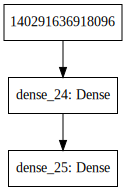

In [116]:
#plot_model(model, to_file='reg_autoencoder.png', show_shapes=True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [117]:
epochs = 100
batch_size = 50

history = model.fit(X_train_np_std, X_train_np_std, batch_size=batch_size, epochs=epochs, validation_data=(X_test_np_std, X_test_np_std))

Train on 984 samples, validate on 247 samples
Epoch 1/100
984/984 [==============================] - 1s 756us/step - loss: 0.1002 - val_loss: 0.0931
Epoch 2/100
984/984 [==============================] - 0s 48us/step - loss: 0.0929 - val_loss: 0.0864
Epoch 3/100
984/984 [==============================] - 0s 54us/step - loss: 0.0868 - val_loss: 0.0811
Epoch 4/100
984/984 [==============================] - 0s 58us/step - loss: 0.0820 - val_loss: 0.0768
Epoch 5/100
984/984 [==============================] - 0s 78us/step - loss: 0.0780 - val_loss: 0.0732
Epoch 6/100
984/984 [==============================] - 0s 59us/step - loss: 0.0747 - val_loss: 0.0703
Epoch 7/100
984/984 [==============================] - 0s 84us/step - loss: 0.0719 - val_loss: 0.0677
Epoch 8/100
984/984 [==============================] - 0s 62us/step - loss: 0.0695 - val_loss: 0.0656
Epoch 9/100
984/984 [==============================] - 0s 76us/step - loss: 0.0676 - val_loss: 0.0638
Epoch 10/100
984/984 [=============

984/984 [==============================] - 0s 87us/step - loss: 0.0189 - val_loss: 0.0182
Epoch 80/100
984/984 [==============================] - 0s 45us/step - loss: 0.0188 - val_loss: 0.0181
Epoch 81/100
984/984 [==============================] - 0s 39us/step - loss: 0.0186 - val_loss: 0.0180
Epoch 82/100
984/984 [==============================] - 0s 61us/step - loss: 0.0185 - val_loss: 0.0179
Epoch 83/100
984/984 [==============================] - 0s 47us/step - loss: 0.0184 - val_loss: 0.0178
Epoch 84/100
984/984 [==============================] - 0s 46us/step - loss: 0.0182 - val_loss: 0.0176
Epoch 85/100
984/984 [==============================] - 0s 52us/step - loss: 0.0181 - val_loss: 0.0175
Epoch 86/100
984/984 [==============================] - 0s 50us/step - loss: 0.0180 - val_loss: 0.0174
Epoch 87/100
984/984 [==============================] - 0s 49us/step - loss: 0.0179 - val_loss: 0.0173
Epoch 88/100
984/984 [==============================] - 0s 45us/step - loss: 0.0178 - 

dict_keys(['val_loss', 'loss'])


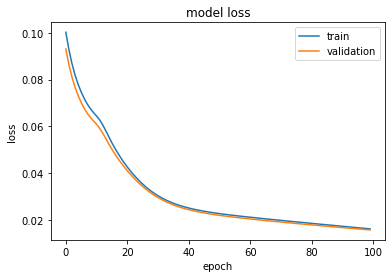

In [118]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## DNN!